# NULL

In [1]:
import numpy as np
import pandas as pd
import time
import random
from scipy.sparse import csr_matrix, lil_matrix

## MNIST handwritten dataset

In [2]:
from sklearn.datasets import fetch_openml
# load MNIST dataset
mnist = fetch_openml('mnist_784')
X = mnist.data / 255.0
y = mnist.target

data = X.copy()
data['label'] = y
X = None
y = None
print('done')

/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


done


# Barnes-Hut-SNE


Select k neighbors in high-dimenstional space in VP-tree

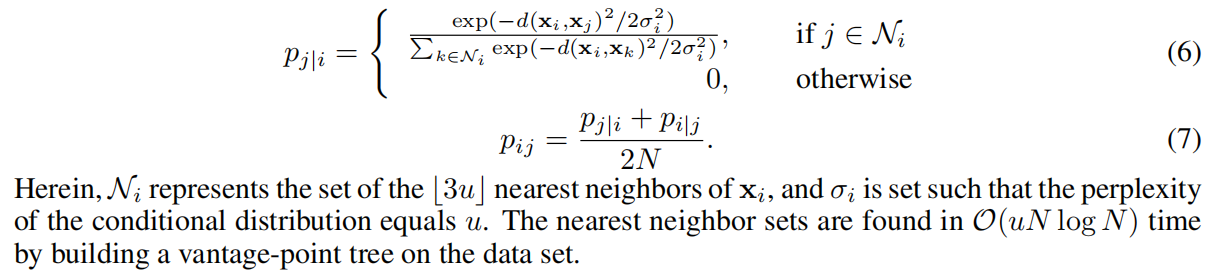

Using the Euclidean distance matrix.

In [3]:
def cal_dis_square(X):
  '''
    X - data matrix(n rows * d dimensions)
    calculate the Euclidean distance
    Using Matrix Operations to speed up

    return D - square distance matrix
    e.g. D[i][j] - the square distance between i and j   (xi - xj)**2
  '''

  sum_X = np.sum(np.square(X), 1)
  D = np.add(np.add(-2 * np.dot(X, X.T), sum_X).T, sum_X)
  row, col = np.diag_indices_from(D)
  D[row,col] = 0
  return D

Build the VP tree to calculate and store the High-dimentional possibility matrix.

using CSR sparse matrix() to speed up

In [4]:
class Node:
  def __init__(self, index, left=None, right=None, radius=None):
    self.index = index
    self.left = left
    self.right = right
    self.radius = radius

class VPTree:
  def __init__(self, D):
    self.dist_matrix = D
    self.root = self.build_tree(np.arange(len(D)))

  def build_tree(self, indices):
    if indices.size == 0:
      return None

    # Select a vantage point
    vp_i = np.random.choice(indices)
    # delete the v-point itself
    indices = np.delete(indices, np.where(indices == vp_i))
    # select the distance instead of the point
    vp = self.dist_matrix[vp_i][indices]

    if indices.size == 0:
      return Node(vp_i, None, None, None)

    # Select median distance as threshold
    threshold = np.median(vp)

    left_indices = indices[vp < threshold]
    right_indices = indices[vp >= threshold]

    return Node(vp_i, self.build_tree(left_indices), self.build_tree(right_indices), threshold)


  def search_tree(self, node, query_index, k, neighbors):
    if node is None:
      return

    dist = self.dist_matrix[node.index, query_index]

    if dist != 0 and node.index != query_index:
      # Check if current node is a nearest neighbor
      tau = max(neighbors.values(), default=float('inf'))
      if (len(neighbors) < k or dist < tau):
        # When neighbors is full, remove the farthest one
        if len(neighbors) == k:
          # Find the index of the farthest neighbor
          farthest_index = max(neighbors, key=neighbors.get)
          del neighbors[farthest_index]
        neighbors[node.index] = dist

    # Check which child to search first
    if node.left is None and node.right is None:
      return

    if dist < node.radius:
      closer, further = node.left, node.right
    else:
      closer, further = node.right, node.left

    self.search_tree(closer, query_index, k, neighbors)

    if abs(node.radius - dist) < max(neighbors.values(), default=float('inf')):
      self.search_tree(further, query_index, k, neighbors)

  def get_neighbors_as_sparse_matrix(self, query_index, k, N):
    neighbors = {}
    self.search_tree(self.root, query_index, k, neighbors)

    row = np.zeros(len(neighbors), dtype=int)
    col = np.array(list(neighbors.keys()))
    data = np.array(list(neighbors.values()))

    sparse_vector = csr_matrix((data, (row, col)), shape=(1, N))

    return sparse_vector


In [5]:
np.random.seed(22)

subset = data.sample(frac=0.05)
print(len(subset))
X = np.array(subset.iloc[:,:-1])
labels = np.array(subset['label'])

D = cal_dis_square(X)
tree = VPTree(D)
print(D[1,1441])
neigh = {}
tree.search_tree(tree.root, 1, 5, neigh)
print(neigh)
neigh = None
print(tree.get_neighbors_as_sparse_matrix(1, 5, D.shape[0]))
print(tree.get_neighbors_as_sparse_matrix(1, 5, D.shape[0]).nnz)
print(tree.get_neighbors_as_sparse_matrix(1, 5, D.shape[0]).shape)
print(tree.get_neighbors_as_sparse_matrix(1, 5, D.shape[0]).indices)
print(tree.get_neighbors_as_sparse_matrix(1, 5, D.shape[0]).indptr)


3500
35.60153787004998
{2633: 33.42216070742021, 2224: 35.86423683198773, 1441: 35.60153787004998, 2606: 35.75080353710112, 2751: 36.18757400999613}
  (0, 1441)	35.60153787004998
  (0, 2224)	35.86423683198773
  (0, 2606)	35.75080353710112
  (0, 2633)	33.42216070742021
  (0, 2751)	36.18757400999613
5
(1, 3500)
[1441 2224 2606 2633 2751]
[0 5]


In [6]:
from scipy.sparse import isspmatrix, diags

def calc_P_and_entropy(D, beta=1.0):
  '''
    D - the square distance (sparse matrix)
    beta - 1 / 2 * (sigma**2)

    return P - Gaussian distribution matrix (like D)
        log_perplexity - for calculating the gradient
  '''

  # Check if D is a sparse matrix
  is_sparse = isspmatrix(D)
  if not is_sparse:
    print('error')

  # Calculate P and sumP
  dist = np.array(D.copy().data)
  P = np.exp(-dist * beta)

  sumP = np.sum(P)

  # try to change beta to make log_perplexity be closer with H
  # H = -sum(p j|i) * logp j|i
  log_perplexity = np.log(sumP) + beta * (np.sum(dist * P) / sumP)
  P = P/sumP

  row = np.zeros(P.shape[0], dtype=int)

  # make P a sparse matrix
  P = csr_matrix((P, (row, D.indices)), shape=D.shape)
  return P, log_perplexity


In [7]:
def b_search_beta(D, init_beta, tol=1e-5, perplexity=30.0, max_iter=50):
  """
    Performs a binary search to get P-values in such a way that each
    conditional Gaussian has the same perplexity.

    D - distance**2
    tol - finish search if the difference less than the value of tol
    perplexity - hyperparameter

    return P - Optimized probability matrix
        beta - Optimized beta

  """

  beta_max = np.inf
  beta_min = -np.inf
  beta = init_beta

  P, log_entropy = calc_P_and_entropy(D, beta)
  diff_log_entropy = log_entropy - np.log(perplexity)

  iter = 0
  # entropy is inversely related to beta
  while np.abs(diff_log_entropy)>tol and iter<max_iter:
    if diff_log_entropy>0:
      beta_min = beta
      if beta_max == np.inf or beta_max == -np.inf:
        beta = beta*2
      else:
        beta = (beta+beta_max)/2.

    else:
      beta_max = beta
      if beta_min == -np.inf or beta_min == -np.inf:
        beta = beta/2
      else:
        beta = (beta + beta_min)/2.

    # compute the entrop again
    P, log_entropy = calc_P_and_entropy(D, beta)
    diff_log_entropy = log_entropy - np.log(perplexity)
    iter = iter+1

  return P, beta


In [8]:
def compute_high_dim_prob(X, perplexity=30, tol=1e-5, max_iter=50):
  """
      Performs a binary search to get P-values in such a way that each
      conditional Gaussian has the same perplexity.
  """
  k = min(perplexity * 3, X.shape[0])
  (N, D) = X.shape
  distances = cal_dis_square(X)
  beta = np.ones((N, 1))
  tree = VPTree(distances)

  p_conditional = lil_matrix((N, N))
  # Search for the optimal sigma(beta) for each sample point
  # and calculate the corresponding P
  for i in range(N):
    if i % 500 ==0:
      print("Compute joint P for %d points" % (i))

    Di = tree.get_neighbors_as_sparse_matrix(i, k, N)
    if Di.nnz == 0:
      print(i)

    p_conditional[i], beta[i] = b_search_beta(Di, beta[i], perplexity=perplexity)

  # Convert to CSR format before further computations
  p_conditional = p_conditional.tocsr()
  # Make it symmetric
  P_join = p_conditional + p_conditional.T
  P_join = P_join / np.sum(P_join)

  # show the value of optimized beta
  print("Mean value of sigma: %f" % np.mean(np.sqrt(1 / beta)))

  return P_join

Build a quadtree, arrange the quadrant based on their position.

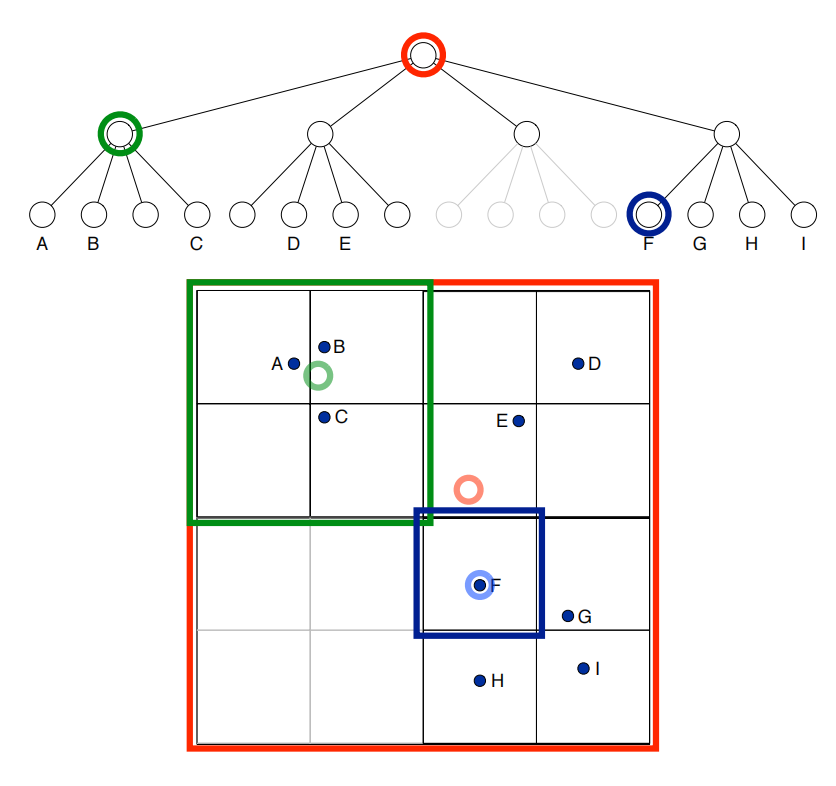

In [9]:
class QuadTree:
  def __init__(self, points, depth=0):
    self.depth = depth
    self.points = points
    self.strength = len(points)

    min_bound = self.points[:, :2].min(axis=0)
    max_bound = self.points[:, :2].max(axis=0)

    self.center = (min_bound + max_bound) / 2
    self.width = max(max_bound - min_bound)

    if len(points) > 1: # determing if it is a leaf node
      self.children = self.divide_into_quadrants()
    else:
      self.children = []

  def divide_into_quadrants(self):
    children = []
    mid = self.center
    tl_points = self.points[np.logical_and(self.points[:, 0] < mid[0], self.points[:, 1] >= mid[1])]
    tr_points = self.points[np.logical_and(self.points[:, 0] >= mid[0], self.points[:, 1] >= mid[1])]
    bl_points = self.points[np.logical_and(self.points[:, 0] < mid[0], self.points[:, 1] < mid[1])]
    br_points = self.points[np.logical_and(self.points[:, 0] >= mid[0], self.points[:, 1] < mid[1])]

    if tl_points.size > 0:
      children.append(QuadTree(tl_points, self.depth + 1))
    if tr_points.size > 0:
      children.append(QuadTree(tr_points, self.depth + 1))
    if bl_points.size > 0:
      children.append(QuadTree(bl_points, self.depth + 1))
    if br_points.size > 0:
      children.append(QuadTree(br_points, self.depth + 1))

    return children

  def cal_qz(self, point, theta=0.5):
    # Compute the distance from the point to the node's center
    dist = np.linalg.norm(point - self.center)

    if dist == 0: return [],[],[]
    qz = []
    Y_i_cell = []
    strengths = []
    if len(self.points) == 1 or self.width / dist < theta:
      # If the node is sufficiently far away, use all of its points as neighbors
      qz.append(1. / (1. + dist**2))
      Y_i_cell.append(point - self.center)
      strengths.append(self.strength)

    else:
      # Otherwise, recurse on the children of the node
      for child in self.children:
        child_qz, child_i_cell, child_strengths = child.cal_qz(point, theta)
        qz.extend(child_qz)
        Y_i_cell.extend(child_i_cell)
        strengths.extend(child_strengths)

    qz=np.array(qz)
    Y_i_cell=np.array(Y_i_cell)
    strengths=np.array(strengths)

    return qz, Y_i_cell, strengths


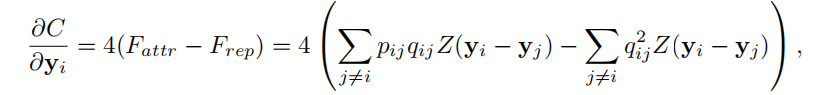

In [10]:
def pca(X=np.array([]), no_dims=50):
  """
    Runs PCA on the NxD array X in order to reduce its dimensionality to
    no_dims dimensions.
  """

  print("Preprocessing the data using PCA...")
  (n, d) = X.shape
  X = X - np.tile(np.mean(X, 0), (n, 1))
  (l, M) = np.linalg.eig(np.dot(X.T, X))
  Y = np.dot(X, M[:, 0:no_dims])
  return Y

###share the sum_Q

In [11]:
def gradient(P: np.array, Y, theta: float):
  qt = QuadTree(Y)
  repulsive_forces, sum_Q = repulsive_forces_gradient(Y, qt, theta)
  attractive_forces, error = attractive_forces_gradient(P, Y, sum_Q)
  total_forse = attractive_forces - repulsive_forces/sum_Q
  return total_forse, error


def repulsive_forces_gradient(Y, qt: QuadTree, theta: float):

  n_sample = Y.shape[0]
  n_dimensions = 2
  repulsive_forces = np.zeros((n_sample, n_dimensions))
  sum_Q = 0
  for i in range(n_sample):
    point = Y[i]
    qz, Y_i_cell, strengths = qt.cal_qz(point, theta)
    NqZ = qz * strengths
    sum_Q += np.sum(NqZ)
    mult = NqZ * qz
    repulsive_forces[i, 0] = np.sum(mult * Y_i_cell[:, 0])
    repulsive_forces[i, 1] = np.sum(mult * Y_i_cell[:, 1])

  return repulsive_forces, sum_Q


def attractive_forces_gradient(P, Y: np.array, sum_Q: float):

  val_P = P.data.astype(np.float32, copy=False)
  neighbors = P.indices.astype(np.int64, copy=False)
  indptr = P.indptr.astype(np.int64, copy=False)

  n_dimensions = Y.shape[1]
  n_sample = indptr.shape[0] - 1
  attractive_forces = np.zeros((n_sample, n_dimensions))
  error = 0
  Q_data = []
  for i in range(n_sample):
    P_neighbors = val_P[indptr[i]: indptr[i+1]]
    y_neighbors = Y[neighbors[indptr[i]: indptr[i+1]]]
    residual = Y[i] - y_neighbors
    q_ij = 1.0 / (1.0 + np.sum(residual**2, axis = 1))
    PQ = P_neighbors * q_ij
    attractive_forces[i, 0] = np.sum(PQ * residual[:, 0])
    attractive_forces[i, 1] = np.sum(PQ * residual[:, 1])
    Q_data.extend(q_ij)
  Q_data = Q_data / sum_Q

  # Compute the error
  error = np.sum(P.data * np.log(P.data / Q_data))

  return attractive_forces, error


# Barnes-HuT-SNE

In [12]:
def bhtsne(X, no_dims=2, theta=0.5, initial_dims=50, perplexity=30.0, eta=500, e_exaggeration=4., max_iter = 1000):
  """
    Runs t-SNE on the dataset in the NxD array X to reduce its
    dimensionality to no_dims dimensions. The syntaxis of the function is
    `Y = tsne.tsne(X, no_dims, perplexity), where X is an NxD NumPy array.

    theta - the width of the cell / the Euclidean distance between the cell and target
    eta - learning rate
  """

  # Check inputs
  if isinstance(no_dims, float):
    print("Error: array X should have type float.")
    return -1
  if round(no_dims) != no_dims:
    print("Error: number of dimensions should be an integer.")
    return -1

  # # using PCA to reduce d to init_dims
  # time_pca = time.time()

  # X = pca(X, initial_dims).real
  (n, d) = X.shape
  # using PCA to reduce d to init_dims
  X = pca(X, initial_dims).real

  # start computing distance and p
  time_p = time.time()

  # Compute joint P-values
  P = compute_high_dim_prob(X)
  P = P * e_exaggeration									# Trick: early exaggeration


  #Initialize randomly for low-dimensional data
  Y = np.random.randn(n, no_dims)

  #hyperparameters of gradient descent with momentum
  initial_momentum = 0.5
  final_momentum = 0.8

  min_gain = 0.01
  dY = np.zeros((n, no_dims)) # gradient
  iY = np.zeros((n, no_dims)) # delta Y
  gains = np.ones((n, no_dims)) # the length of steps

  # early stopping
  tolerance = 1e-4
  patience_counter = 0
  best_error = 99999
  patience_limit = 100

  # Run iterations
  for iter in range(max_iter):

    dY, error = gradient(P, Y, theta)

    # Perform the update
    if iter < 20:
      momentum = initial_momentum
    else:
      momentum = final_momentum

    # If dY and iY are in the same direction, gains+=2;
    # otherwise, gains *= 0.8
    # i.e. If the direction of gradient descent remains the same it increases the gains and vice versa.
    gains = (gains + 0.2) * ((dY > 0.) != (iY > 0.)) + \
          (gains * 0.8) * ((dY > 0.) == (iY > 0.))
    gains[gains < min_gain] = min_gain
    iY = momentum * iY - eta * (gains * dY)
    Y += iY

    # Ensure that the centre of the distribution remains at the origin in each iteration
    Y = Y - np.tile(np.mean(Y, 0), (n, 1))

    # Check for early stopping
    if best_error-error < tolerance:
      patience_counter += 1
    else:
      patience_counter = 0

    if error < best_error:
      best_error = error

    if patience_counter >= patience_limit:
      print(f"Early stopping at iteration {iter}, the final error is {error}")
      break

    # Compute current value of cost function( KL(P||Q) )
    if (iter + 1) % 100 == 0:
      print("Iteration %d: error is %f" % (iter + 1, error))

    # Stop lying about P-values
    if iter == 100:
      P = P / e_exaggeration

  time_end = time.time()

  time_total = time_end - time_p


  print('Barnes-HuT-SNE Done! Time: {} seconds'.format(time_total))
  # Return solution
  return Y

# Interpolation-based BH-SNE

In [17]:
def bhtsne(X, no_dims=2, theta=0.5, initial_dims=50, perplexity=30.0, eta=500, e_exaggeration=4., tolerance=1e-4, max_iter = 1000):
  """
    Runs t-SNE on the dataset in the NxD array X to reduce its
    dimensionality to no_dims dimensions. The syntaxis of the function is
    `Y = tsne.tsne(X, no_dims, perplexity), where X is an NxD NumPy array.

    theta - the width of the cell / the Euclidean distance between the cell and target
    eta - learning rate
  """

  # Check inputs
  if isinstance(no_dims, float):
    print("Error: array X should have type float.")
    return -1
  if round(no_dims) != no_dims:
    print("Error: number of dimensions should be an integer.")
    return -1

  # # using PCA to reduce d to init_dims
  # time_pca = time.time()

  # X = pca(X, initial_dims).real
  (n, d) = X.shape
  # using PCA to reduce d to init_dims
  X = pca(X, initial_dims).real

  # start computing distance and p
  t_P = time.time()

  # Compute joint P-values
  P = compute_high_dim_prob(X)
  P = P * e_exaggeration									# Trick: early exaggeration
  print("-----pairwise similarity done. It costs %f seconds.-----" % (time.time()-t_P))


  #Initialize randomly for low-dimensional data
  Y = np.random.randn(n, no_dims)

  #hyperparameters of gradient descent with momentum
  initial_momentum = 0.5
  final_momentum = 0.8

  min_gain = 0.01
  dY = np.zeros((n, no_dims)) # gradient
  iY = np.zeros((n, no_dims)) # delta Y
  gains = np.ones((n, no_dims)) # the length of steps

  # early stopping
  patience_counter = 0
  best_error = 99999
  patience_limit = 200

  t_Q = time.time()
  # Run iterations
  for iter in range(max_iter):

    dY, error = gradient(P, Y, theta)

    # Perform the update
    if iter < 20:
      momentum = initial_momentum
    else:
      momentum = final_momentum

    # If dY and iY are in the same direction, gains+=2;
    # otherwise, gains *= 0.8
    # i.e. If the direction of gradient descent remains the same it increases the gains and vice versa.
    gains = (gains + 0.2) * ((dY > 0.) != (iY > 0.)) + \
          (gains * 0.8) * ((dY > 0.) == (iY > 0.))
    gains[gains < min_gain] = min_gain
    iY = momentum * iY - eta * (gains * dY)
    Y += iY

    # Ensure that the centre of the distribution remains at the origin in each iteration
    Y = Y - np.tile(np.mean(Y, 0), (n, 1))

    # Check for early stopping
    if best_error-error < tolerance:
      patience_counter += 1
    else:
      patience_counter = 0

    if error < best_error:
      best_error = error

    if patience_counter >= patience_limit:
      print(f"Early stopping at iteration {iter}, the final error is {error}")
      break

    # Compute current value of cost function( KL(P||Q) )
    if (iter + 1) % 100 == 0:
      print("Iteration %d: error is %f" % (iter + 1, error))

    # Stop lying about P-values
    if iter == 100:
      P = P / e_exaggeration

  print("-----pairwise similarity done. It costs %f seconds.-----" % (time.time()-t_Q))

  # Return solution
  return Y

# Outputs

draw the graph

In [14]:
import matplotlib.pyplot as plt
def draw_pic(X ,labs, name = 't-sne.jpg'):
  plt.cla()
  unque_labs = np.unique(labs)
  colors = [plt.cm.Spectral(each)
    for each in np.linspace(0, 1,len(unque_labs))]
  p=[]
  legends = []
  for i in range(len(unque_labs)):
    index = np.where(labs==unque_labs[i])
    pi = plt.scatter(X[index, 0], X[index, 1], c =[colors[i]] )
    p.append(pi)
    legends.append(unque_labs[i])

  plt.legend(p, legends)
  plt.savefig(name)

using 1000 lines of MNIST data

In [15]:
# use 1000 lines for test
np.random.seed(22)

subset = data.sample(5000)
print(subset['label'].value_counts())

1    578
7    537
9    524
8    521
6    484
4    482
2    473
3    472
5    469
0    460
Name: label, dtype: int64


Preprocessing the data using PCA...
Compute joint P for 0 points
Compute joint P for 500 points
Compute joint P for 1000 points
Compute joint P for 1500 points
Compute joint P for 2000 points
Compute joint P for 2500 points
Compute joint P for 3000 points
Compute joint P for 3500 points
Compute joint P for 4000 points
Compute joint P for 4500 points
Mean value of sigma: 2.137924
-----pairwise similarity done. It costs 162.947625 seconds.-----
Iteration 100: error is 6.229420
Iteration 200: error is 1.811412
Iteration 300: error is 1.667496
Iteration 400: error is 1.619857
Iteration 500: error is 1.598059
Iteration 600: error is 1.583067
Iteration 700: error is 1.574056
Iteration 800: error is 1.566694
Iteration 900: error is 1.559700
Iteration 1000: error is 1.553869
Iteration 1100: error is 1.548623
Iteration 1200: error is 1.544040
Iteration 1300: error is 1.539414
Iteration 1400: error is 1.536321
Iteration 1500: error is 1.532306
-----pairwise similarity done. It costs 20612.466098

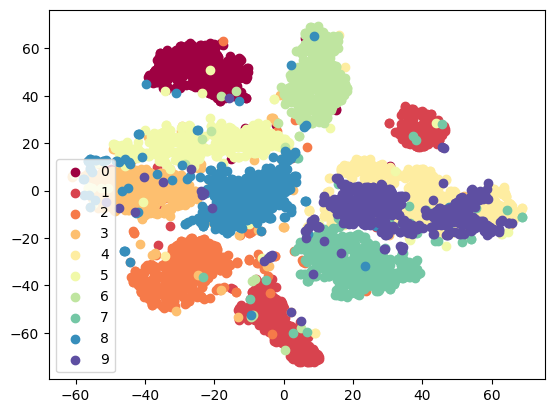

In [18]:
t1 = time.time()
X = np.array(subset.iloc[:,:-1])
labels = np.array(subset['label'])

Y_bh = bhtsne(X, no_dims=2, theta=0.5, initial_dims=50, perplexity=30.0, eta=600, e_exaggeration=2, tolerance=1e-4, max_iter=1500) # 1000 data
print('Barnes-HuT-SNE Done! Time: {} seconds'.format(time.time()-t1))
draw_pic(Y_bh, labels, name = "final.jpg")

# Previous results

bh t-sne

Preprocessing the data using PCA...
Compute joint P for 0 points
Compute joint P for 500 points
Mean value of sigma: 2.704229
Iteration 100: error is 4.757765
Iteration 200: error is 1.062240
Iteration 300: error is 1.036594
Iteration 400: error is 1.027948
Iteration 500: error is 1.024040
Iteration 600: error is 1.020217
Iteration 700: error is 1.018750
Iteration 800: error is 1.016517
Iteration 900: error is 1.014918
Iteration 1000: error is 1.014073
Iteration 1100: error is 1.013398
Early stopping at iteration 1167, the final error is 1.0132207834479483
Barnes-HuT-SNE Done! Time: 2022.697199344635 seconds


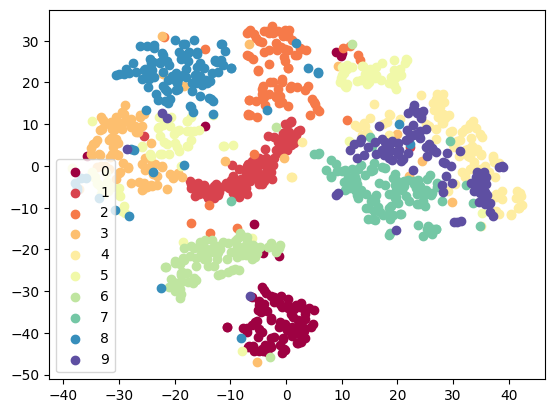

In [ ]:
X = np.array(subset.iloc[:,:-1])
labels = np.array(subset['label'])

Y_bh = bhtsne(X, no_dims=2, theta=0.5, initial_dims=50, perplexity=30.0, eta=600, e_exaggeration=2, tolerance=1e-4, max_iter=1500) # 1000 data

draw_pic(Y_bh, labels, name = "final.jpg")

## Prepackaged method

bh t-sne

time:8.620587587356567


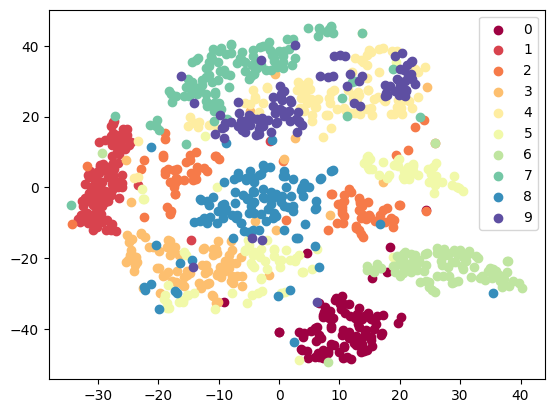

In [ ]:
import numpy as np
from sklearn.manifold import TSNE
t1 = time.time()
X = np.array(subset.iloc[:,:-1])
labels = np.array(subset['label'])

Y = TSNE(n_components=2, learning_rate='auto',
                   method='barnes_hut',init='random', perplexity=30).fit_transform(X)
draw_pic(Y, labels, name = "final.jpg")
print('time:{}'.format(time.time()-t1))

standard t-sne

time:27.28359317779541


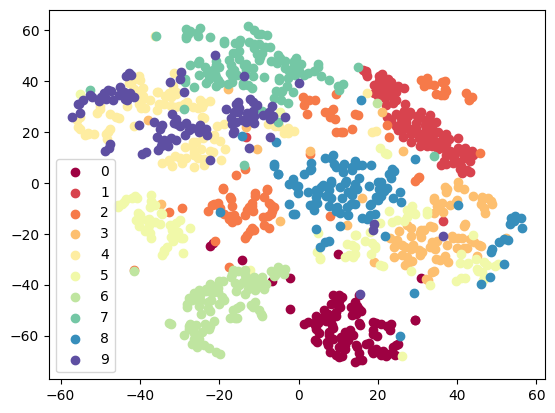

In [ ]:
import numpy as np
from sklearn.manifold import TSNE
t1 = time.time()
X = np.array(subset.iloc[:,:-1])
labels = np.array(subset['label'])

Y = TSNE(n_components=2, learning_rate='auto',
                   method='exact',init='random', perplexity=30).fit_transform(X)
draw_pic(Y, labels, name = "final.jpg")
print('time:{}'.format(time.time()-t1))